#**ARI**

In [20]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/ARI-Historical-Data.csv')
df1=df.reset_index()['Price']

In [22]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [23]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [24]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [25]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [26]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [27]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [28]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 38ms/step - loss: 0.3524 - val_loss: 0.0079
Epoch 2/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0152 - val_loss: 6.6228e-04
Epoch 3/100
15/15 [==============================] - 0s 25ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 4/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0039 - val_loss: 6.4613e-04
Epoch 6/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0036 - val_loss: 6.5667e-04
Epoch 7/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0034 - val_loss: 5.7912e-04
Epoch 8/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0032 - val_loss: 5.7825e-04
Epoch 9/100
15/15 [==============================] - 0s 24ms/step - loss: 0.0030 - val_loss: 5.0391e-04
Epoch 10/100
15/15 [==============================] - 0s 22ms/step - loss: 0

In [29]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 13ms/step


In [30]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [31]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 17.354619166195583
Testing RMSE: 17.551165297488197


In [32]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 91,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.911768]
92
[0.911768]
93
[0.911768]
94
[0.911768]
95
[0.911768]
96
[0.911768]
97
[0.911768]
98
[0.911768]
99
[0.911768]
100
[0.911768]
101
10 day input [0.90673575 0.90479275 0.90414508 0.90932642 0.90349741 0.90479275
 0.9015544  0.89831606 0.90090674 0.93588083 0.92810881 0.92163212
 0.9138601  0.90803109 0.90932642 0.90284974 0.89248705 0.8892487
 0.88471503 0.8873057  0.88601036 0.8892487  0.875      0.87759067
 0.88536269 0.88536269 0.90284974 0.89702073 0.87759067 0.87823834
 0.88471503 0.88082902 0.88212435 0.88277202 0.8873057  0.88406736
 0.88601036 0.88536269 0.89572539 0.89766839 0.90608808 0.88989637
 0.89507772 0.90414508 0.89572539 0.89183938 0.89183938 0.88665803
 0.88406736 0.88536269 0.89313472 0.88341969 0.88536269 0.89378238
 0.89378238 0.90414508 0.90608808 0.89831606 0.89119171 0.89183938
 0.90673575 0.91256477 0.90479275 0.91645078 0.91645078 0.90997409
 0.91256477 0.93134715 0.93911917 0.9384715  0.92681347 0.92810881
 0.93393782 0.95595855 0.96632124 0.966968

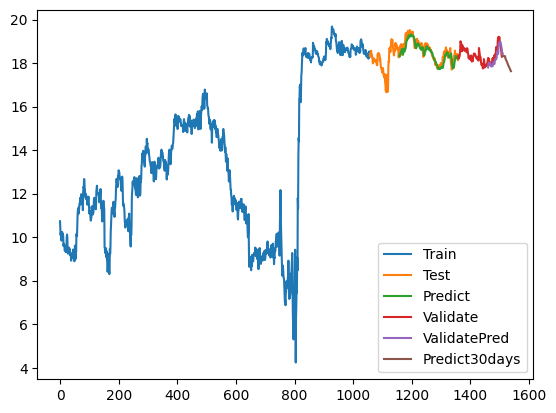

In [33]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

#**MAA**

In [34]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/MAA-Historical-Data.csv')
df1=df.reset_index()['Price']

In [36]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [37]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [38]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [39]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [40]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [41]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [42]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 3s 68ms/step - loss: 0.1158 - val_loss: 0.0536
Epoch 2/100
15/15 [==============================] - 1s 39ms/step - loss: 0.0165 - val_loss: 0.0056
Epoch 3/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 4/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/100
15/15 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 5.8204e-04
Epoch 6/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 8.2855e-04
Epoch 7/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 5.0742e-04
Epoch 8/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0012 - val_loss: 4.4611e-04
Epoch 9/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 4.2166e-04
Epoch 10/100
15/15 [==============================] - 0s 22ms/step - loss: 0.001

In [43]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 18ms/step


In [44]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [45]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 104.26332372412472
Testing RMSE: 95.42363225786909


In [46]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 91,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.13857503]
92
[0.13857503]
93
[0.13857503]
94
[0.13857503]
95
[0.13857503]
96
[0.13857503]
97
[0.13857503]
98
[0.13857503]
99
[0.13857503]
100
[0.13857503]
101
10 day input [0.16474408 0.16350073 0.16066865 0.16294812 0.16032327 0.15548802
 0.15562617 0.15341576 0.14726808 0.14768253 0.15500449 0.15362299
 0.15534987 0.15610969 0.15631692 0.15907992 0.16294812 0.16267182
 0.15431374 0.14906403 0.15465911 0.16881951 0.16073772 0.15445189
 0.14989293 0.15072183 0.14885681 0.15051461 0.15161981 0.1458175
 0.14961663 0.15486634 0.15749119 0.15852732 0.15348484 0.15735304
 0.14574843 0.15092906 0.15210334 0.15493541 0.14871866 0.13366029
 0.13683774 0.14105132 0.13600884 0.13366029 0.13186434 0.13310769
 0.13248601 0.13269324 0.13027561 0.13151896 0.12592388 0.12136492
 0.11563169 0.12046695 0.11411204 0.11286869 0.11487187 0.11224701
 0.11445742 0.10872418 0.10409615 0.10471783 0.10306003 0.11024384
 0.1222629  0.11659874 0.14264005 0.1466464  0.1430545  0.14457415
 0.14906403 0.15231056

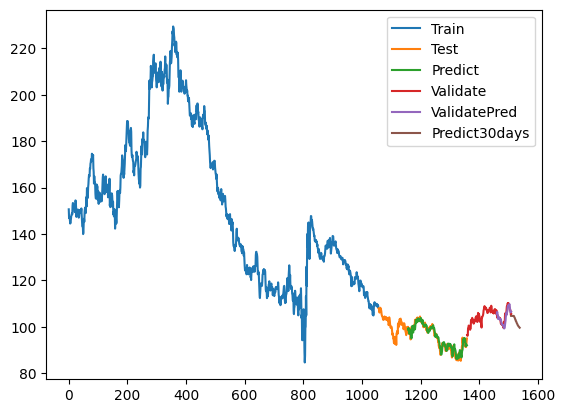

In [47]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

#**ARE**

In [5]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/ARE-Historical-Data.csv')
df1=df.reset_index()['Price']

In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [9]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [12]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 40ms/step - loss: 0.0246 - val_loss: 0.0064
Epoch 2/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/100
15/15 [==============================] - 1s 54ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 4/100
15/15 [==============================] - 1s 70ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 5/100
15/15 [==============================] - 1s 84ms/step - loss: 0.0019 - val_loss: 9.1543e-04
Epoch 6/100
15/15 [==============================] - 1s 64ms/step - loss: 0.0017 - val_loss: 7.3173e-04
Epoch 7/100
15/15 [==============================] - 1s 62ms/step - loss: 0.0016 - val_loss: 6.4418e-04
Epoch 8/100
15/15 [==============================] - 1s 68ms/step - loss: 0.0016 - val_loss: 6.3657e-04
Epoch 9/100
15/15 [==============================] - 1s 51ms/step - loss: 0.0014 - val_loss: 5.0671e-04
Epoch 10/100
15/15 [==============================] - 1s 45ms/step - loss: 0.001

In [14]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 10ms/step


In [15]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 119.56568067280487
Testing RMSE: 124.41384618811131


In [18]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 91,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.09200225]
92
[0.09200225]
93
[0.09200225]
94
[0.09200225]
95
[0.09200225]
96
[0.09200225]
97
[0.09200225]
98
[0.09200225]
99
[0.09200225]
100
[0.09200225]
101
10 day input [0.10177421 0.09427134 0.08976962 0.08915173 0.08588578 0.07626445
 0.07467561 0.0767058  0.06355371 0.06425986 0.07838291 0.07520523
 0.06867332 0.07997175 0.08006002 0.08579751 0.08950481 0.0903875
 0.09312384 0.08085444 0.08579751 0.0889752  0.08014829 0.0866802
 0.08924    0.08976962 0.09727249 0.09736076 0.08050137 0.07388119
 0.07961868 0.09012269 0.09700768 0.09418307 0.08632713 0.09541884
 0.08588578 0.10053844 0.10256863 0.09886133 0.10115632 0.0818254
 0.08482655 0.09312384 0.09127019 0.09091712 0.09118192 0.0926825
 0.0903875  0.09471268 0.09683114 0.08932827 0.09330038 0.09303557
 0.08703328 0.0903875  0.09462442 0.1040692  0.10424574 0.09197634
 0.09577191 0.08615059 0.07458734 0.07750022 0.06681967 0.06117045
 0.07282196 0.06946774 0.08888693 0.09418307 0.08994616 0.07688234
 0.09047577 0.09992056 0.

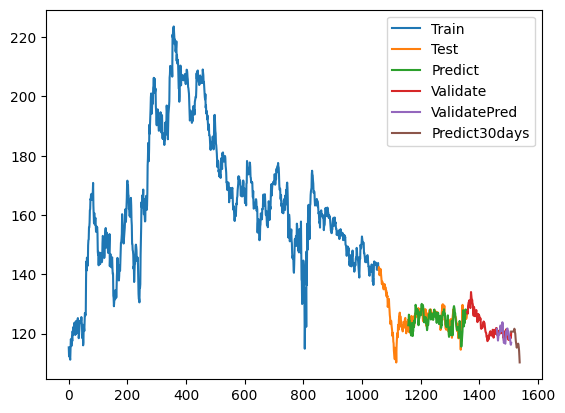

In [19]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()